<a href="https://colab.research.google.com/github/Abhilash437/GNN-Notebooks/blob/main/Word2Vec1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import torch
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import random

dog_cat_words = ['dog', 'cat', 'pet', 'house', 'animal', 'sleep', 'play']
family_words = ['girl', 'boy', 'father', 'mother', 'family', 'house', 'marriage']
king_queen_words = ['crown', 'queen', 'king', 'empire', 'country', 'rule', 'castle']

dog_cat_text = ''
family_text = ''
king_queen_text = ''

for i in range(10000):
  random.shuffle(dog_cat_words)
  dog_cat_text = dog_cat_text + ' ' + ' '.join(dog_cat_words)

  random.shuffle(family_words)
  family_text = family_text + ' ' + ' '.join(family_words)

  random.shuffle(king_queen_words)
  king_queen_text = king_queen_text + ' ' + ' '.join(king_queen_words)

small_corpus = dog_cat_text + family_text + king_queen_text

small_corpus


' pet dog play house sleep cat animal sleep play animal house cat pet dog house dog cat sleep pet play animal sleep cat pet dog house play animal dog cat house play pet sleep animal play cat pet dog animal sleep house animal house play sleep pet dog cat dog pet house cat play sleep animal pet sleep dog animal house play cat house dog sleep cat pet animal play pet house cat dog animal sleep play pet animal sleep house dog cat play sleep dog pet cat house play animal play dog animal house cat pet sleep sleep play house pet cat animal dog sleep play animal pet dog cat house pet dog play cat animal sleep house cat play house dog animal pet sleep animal house sleep dog cat play pet dog cat animal house pet sleep play dog cat animal house play sleep pet dog animal pet cat sleep play house pet sleep cat dog animal house play play animal dog cat pet house sleep house animal pet cat play sleep dog animal play dog cat pet sleep house house sleep animal pet dog cat play sleep house animal cat dog

In [ ]:
def extract_unique_words(words):
  words = word_tokenize(words.lower())

  words = [word for word in words if word.isalpha()]

  # Count the number of words and unique words
  print("# of words in the text: ", len(words))

  unique_words = sorted(set(words))
  print("# of unqiue words in the text: ", len(unique_words))

  return unique_words

unique_words = extract_unique_words(small_corpus)

# of words in the text:  210000
# of unqiue words in the text:  20


In [ ]:
def gen_cbow(text, window_size):
  text = text.lower()
  words = word_tokenize(text)

  words = [word for word in words if word.isalpha()]

  stop_words = set(stopwords.words('english'))
  words = [word for word in words if word not in stop_words]

  cbows = []
  for i, target_word in enumerate(words):
    context_words = words[max(0, i-window_size):i] + words[i+1: i+window_size+1]

    if len(context_words) == window_size * 2:
      cbows.append((context_words, target_word))

  return cbows

cbows_generated = gen_cbow(small_corpus, 3)

print(cbows_generated[:3])

[(['pet', 'dog', 'play', 'sleep', 'cat', 'animal'], 'house'), (['dog', 'play', 'house', 'cat', 'animal', 'sleep'], 'sleep'), (['play', 'house', 'sleep', 'animal', 'sleep', 'play'], 'cat')]


In [ ]:
def one_hot_encoding(word, unique_words):
  encoding = [1 if word == w else 0 for w in unique_words]
  return torch.tensor(encoding, dtype = torch.float32)

one_hot_encodings = {word: one_hot_encoding(word, unique_words) for word in unique_words}

In [ ]:
cbow_vector_pair = [([one_hot_encodings[word] for word in context_words], one_hot_encodings[target_words]) for context_words, target_words in cbows_generated]

cbow_vector_pair = [(torch.sum(torch.stack(context_vectors), dim=0), target_vector) for context_vectors, target_vector in cbow_vector_pair]

In [ ]:
cbow_vector_pair[0]# contains the 6 context word one-hot encoded vectors

(tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        dtype=torch.int32))

In [ ]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from collections import deque
import matplotlib.pyplot as plt

import json

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.inputs = [item[0] for item in data]
        self.outputs = [item[1] for item in data]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_sample = self.inputs[idx]
        output_sample = self.outputs[idx]
        return input_sample, output_sample

In [ ]:
# Shuffle pairs before training
cbow_vector_pair = random.sample(cbow_vector_pair, len(cbow_vector_pair))

# Train and Val split
split_index = int(len(cbow_vector_pair) * 0.90)

# Split the data into training and test sets
train_dataset = CustomDataset(cbow_vector_pair[:split_index])
test_dataset = CustomDataset(cbow_vector_pair[split_index:])

# Set batch size
batch_size = 64  # You can adjust this based on your requirements

# Create DataLoader for training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class NaiveWord2Vec(nn.Module):

    def __init__(self, VOCAB_SIZE, VECTOR_DIM) -> None:
        super().__init__()

        self.vocab_size = VOCAB_SIZE
        self.vector_dim = VECTOR_DIM
        self.W1 = nn.Parameter(data=torch.randn(self.vocab_size, self.vector_dim), requires_grad=True) # Word Vectors
        self.W2 = nn.Parameter(data=torch.randn(self.vector_dim, self.vocab_size), requires_grad=True)

    def forward(self, X) -> torch.tensor:
        X = X @ self.W1  # Unsqueeze and permute
        X = X @ self.W2

        return X

In [ ]:
VOCAB_SIZE = len(unique_words)
VECTOR_DIM = 2

model = NaiveWord2Vec(VOCAB_SIZE, VECTOR_DIM)

In [ ]:
def train_model(model, train_dataloader, validation_dataloader, epochs, learning_rate, verbose=False):

    # Create the loss function
    loss_fn = nn.CrossEntropyLoss()
    # Create the optimizer object
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    # Log the loss values
    train_set_loss_log = []
    validation_set_loss_log = []

    for epoch in range(epochs):
        if verbose: print("Epoch: ", epoch)
        # Training mode on
        model.train()
        total_train_loss = 0.0
        num_train_batches = 0

        for inputs_batch, outputs_batch in train_dataloader:

            y_train_logits = model(inputs_batch)
            train_loss = loss_fn(y_train_logits, outputs_batch)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            total_train_loss += train_loss.item()
            num_train_batches += 1

        # Calculate average training loss for the epoch
        average_train_loss = total_train_loss / num_train_batches
        train_set_loss_log.append(average_train_loss)

        # Eval mode on
        model.eval()
        total_validation_loss = 0.0
        num_validation_batches = 0

        with torch.inference_mode():
            for inputs_batch, outputs_batch in validation_dataloader:
                # Evaluate the validation loss
                y_val_logits = model(inputs_batch)
                validation_loss = loss_fn(y_val_logits, outputs_batch)

                total_validation_loss += validation_loss.item()
                num_validation_batches += 1

        # Calculate average validation loss for the epoch
        average_validation_loss = total_validation_loss / num_validation_batches
        validation_set_loss_log.append(average_validation_loss)

        if verbose: print("Train Loss: ", average_train_loss, "|||", "Validation Loss: ", average_validation_loss)


    return model, train_set_loss_log, validation_set_loss_log

In [ ]:
model, train_set_loss_log, validation_set_loss_log = train_model(model, train_dataloader, validation_dataloader,
                                                                 epochs=3, learning_rate=0.01, verbose=True)

Epoch:  0
Train Loss:  2.024998325791485 ||| Validation Loss:  1.8548542801007675
Epoch:  1
Train Loss:  1.856979681134789 ||| Validation Loss:  1.8505036892499604
Epoch:  2
Train Loss:  1.8528745177636377 ||| Validation Loss:  1.8508553689736362


In [ ]:
params = list(model.parameters())
word_vectors = params[0].detach()

# Create a dictionary with the same order mapping
word_dict = {word: vector for word, vector in zip(unique_words, word_vectors)}

In [ ]:
word_dict

{'animal': tensor([-0.2497,  0.8735]),
 'boy': tensor([0.8483, 0.3160]),
 'castle': tensor([-2.1472, -2.0626]),
 'cat': tensor([-0.2249,  0.6958]),
 'country': tensor([-0.1349, -0.1827]),
 'crown': tensor([-0.0871, -0.1578]),
 'dog': tensor([-0.2604,  0.6879]),
 'empire': tensor([ 0.0869, -0.2798]),
 'family': tensor([1.1888, 0.4313]),
 'father': tensor([2.0502, 0.9018]),
 'girl': tensor([1.2341, 0.3073]),
 'house': tensor([-0.4772, -1.2398]),
 'king': tensor([ 1.1314, -3.7687]),
 'marriage': tensor([0.8310, 0.4839]),
 'mother': tensor([0.6606, 0.2951]),
 'pet': tensor([-0.2375,  0.7976]),
 'play': tensor([-0.3059,  1.0024]),
 'queen': tensor([-0.0951, -0.3229]),
 'rule': tensor([-0.0109, -0.2674]),
 'sleep': tensor([-0.6456,  2.0109])}

In [ ]:
def cosine_similarity(v1, v2):
    return (v1 @ v2) / (torch.norm(v1) * torch.norm(v2))

def most_similar(word, word_dict, top_k=5):
    if word not in word_dict:
        raise ValueError(f"{word} not found in the word dictionary.")

    query_vector = word_dict[word]

    # Calculate cosine similarity with all other words in the dictionary
    similarities = {}
    for other_word, other_vector in word_dict.items():
        if other_word != word:
            similarity = cosine_similarity(query_vector, other_vector)
            similarities[other_word] = similarity

    # Sort the words by similarity in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Get the top-k most similar words
    top_similar_words = sorted_similarities[:top_k]

    return top_similar_words

In [ ]:
most_similar('dog', word_dict)

[('cat', tensor(0.9988)),
 ('sleep', tensor(0.9987)),
 ('play', tensor(0.9978)),
 ('pet', tensor(0.9974)),
 ('animal', tensor(0.9965))]

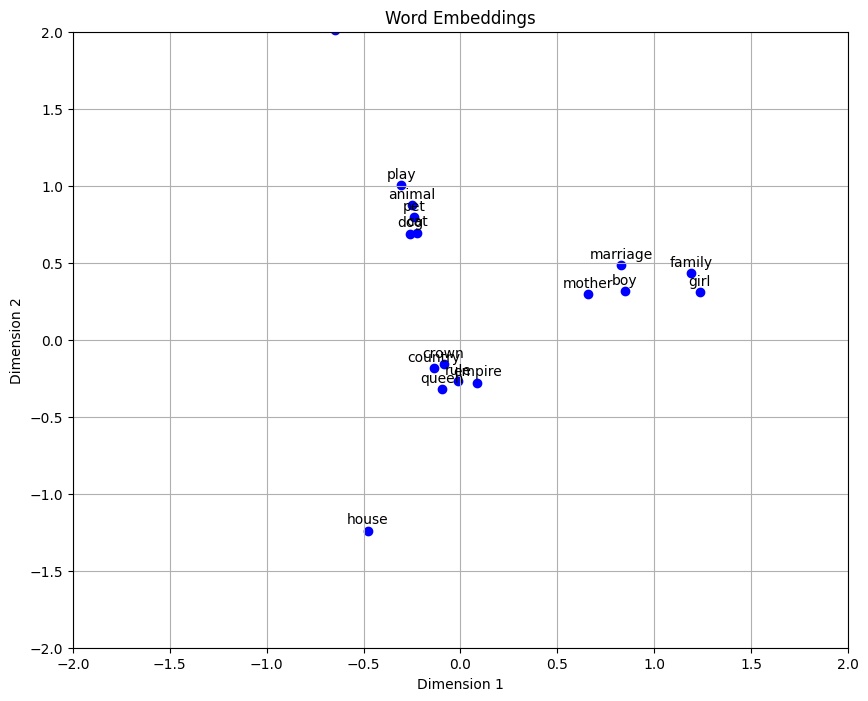

In [ ]:
x_coords, y_coords = zip(*[word_dict[word].numpy() for word in list(word_dict.keys())])

plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, marker='o', color='blue')

for i, word in enumerate(list(word_dict.keys())):
    plt.annotate(word, (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()